We need to :

1. generate data
2. define priors in lim space
3. do inference in limited space
4. in inference expand space for update
5. shrink back for global update 
6. repeat till convergence

Stuff thats different :

Dirichlet(a_11 , ... , a_1n )= Dirichlet (a_12, ... ,a_1N) i.e. the diagonal entry of the transition matrix is set to 0 


In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from pybasicbayes.distributions import Gaussian
from sklearn.cluster import KMeans

/Users/lenkasefcakova/Desktop/VI-sandbox/pybasicbayes/distributions/multinomial.py:21: UserWarning: using slow sample_crp_tablecounts
  warn('using slow sample_crp_tablecounts')
/Users/lenkasefcakova/Desktop/VI-sandbox/pybasicbayes/distributions/negativebinomial.py:25: UserWarning: using slow sample_crp_tablecounts
  warn('using slow sample_crp_tablecounts')


In [2]:
centers = np.array([np.array([0,0]),np.array([4,4]),np.array([0,6]),np.array([8,6])])


K = 4           # number of states  
D = 2        #have to be equal (symmetry)
kappa_0 = 1.5     #??? variance of emissions ?
nu_0 = 4        #??? smoothing?

T = np.array([
    [0,0.3,0.6,0.1],
    [0.2,0,0.7,0.1],
    [0.7,0.2,0,0.1],
    [0.7,0.2,0.1,0]
    ])

N = 1000
lambda_js = [5,4,2,7]


from generate_data import *
emit = make_emissions(centers , kappa_0, nu_0)

seq_hsmm, ind = generate_states_pois(T,lambda_js,N)



obs_hsmm = generate_data(emit,ind)

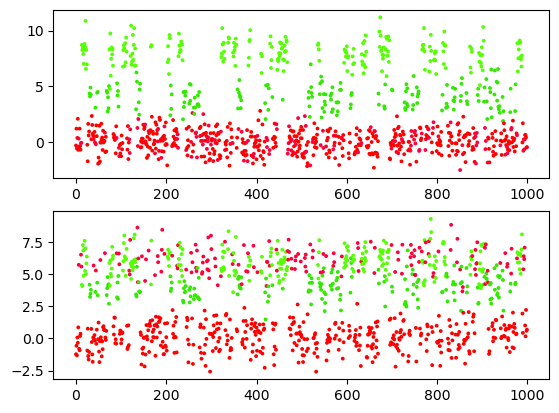

In [3]:
fig, axs = plt.subplots(2, 1)

axs[0].scatter([i for i in range(N)],obs_hsmm[:,0],s=3, c =seq_hsmm ,cmap = 'prism')
axs[1].scatter([i for i in range(N)],obs_hsmm[:,1],s=3, c =seq_hsmm ,cmap = 'prism')

In [4]:
from matrix_expansion import expand_matrix
a_js = [7,6,5,6]
T_HMM = expand_matrix(T, lambda_js , a_js)
T_HMM.shape

(24, 24)

In [5]:
kmeans = KMeans(init="random",n_clusters=K,n_init=10,max_iter=300,random_state=1)
kmeans.fit(obs_hsmm)

mu_0 = kmeans.cluster_centers_ #np.zeros(D)
sigma_0 = 0.75*np.cov(obs_hsmm.T)
kappa_0 = 10 # high value for stability (low rescale when Gaussian mu_0 --> mu_mf resample(--> nat_to_standard()))
# if we use the KMeans we are pretty confident in the centers so we can set a high value
# consult this step with Jack and Benni !!!!!!!!!!!!!
nu_0 = 4

# define emissions for each super state
prior_emit = [Gaussian(mu_0=mu_0[i], sigma_0=sigma_0, kappa_0=kappa_0, 
                        nu_0=nu_0) for i in range(K)]
prior_emit = np.array(prior_emit)           # prior on emissions retype
prior_tran = np.ones(K*K).reshape((K,K))    # prior on transition matrix all 1
np.fill_diagonal(prior_tran, 0)

prior_init = np.ones(K)                     # ?
# -----------------------------------------------------------------
# page break


[0.25 0.25 0.25 0.25]
var_exp is [[1317.65968323 1317.8537123  1317.82510031 1317.79704284 1317.77286701
  1317.75328396 1317.76058955 1317.44169247 1317.6924547  1317.66717113
  1317.64817025 1317.63468498 1317.62513945 1317.3755098  1317.62932311
  1317.61585588 1317.6080766  1317.6031888  1317.82408986 1318.11176698
  1318.09360818 1318.0670504  1318.03538502 1318.12884636]
 [1317.66880509 1317.85629984 1317.84075752 1317.80897406 1317.7811746
  1317.75851403 1317.77915671 1317.39352896 1317.70309605 1317.67743779
  1317.65814157 1317.64443869 1317.63473933 1317.32586593 1317.63852677
  1317.62485408 1317.61695482 1317.61199116 1317.78741796 1318.07948345
  1318.10264988 1318.07634347 1318.04486808 1318.13118458]
 [1317.70045211 1317.89734196 1317.87849935 1317.8499202  1317.82426214
  1317.80331853 1317.81316074 1317.44020698 1317.71461918 1317.6897974
  1317.67102858 1317.65770029 1317.6484722  1317.37358833 1317.65191876
  1317.63867491 1317.63102601 1317.62622065 1317.80128972 1

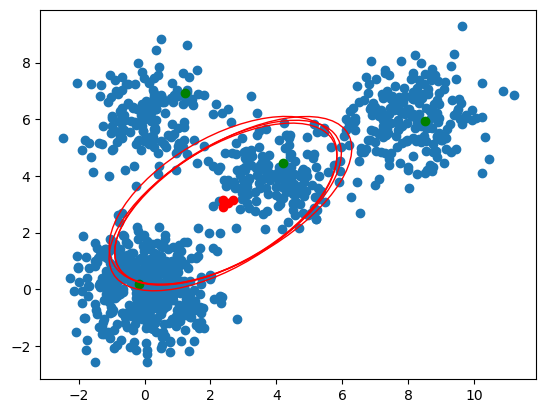

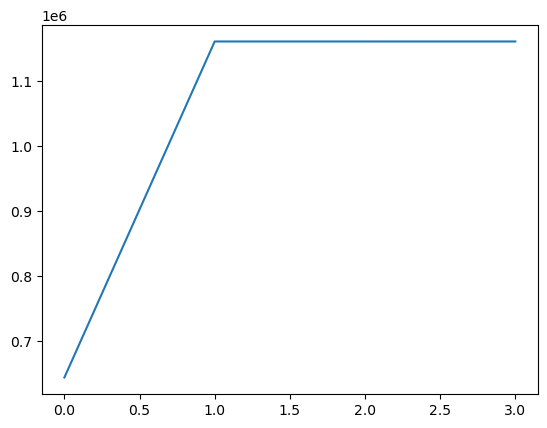

In [6]:
import hmmbatchcd as HSMM
import util

# define object for inferrence from hmmbatchcd.py
# # pass priors on init transitions and emissions for each state
hmm = HSMM.VBHSMM(obs_hsmm, prior_init, prior_tran, prior_emit,prior_expansion_param=lambda_js,prior_expansion_lengths =  a_js,maxit=4, epsilon=10**(-10))  
hmm.infer() # do inference 
sts_true = seq_hsmm # true states 
# hamming distance
##print(prior_emit[0].mu_mf)
##print('Hamming Distance = ', hmm.hamming_dist(hmm.var_x, sts_true)[0]) 

# plot learned emissions over observations

# plots mean_field values (prior in green, posterior approximations in red)
# prior values are green
# var_emit are red 
a = util.plot_emissions(obs_hsmm, prior_emit, hmm.var_emit)
plt.show()

# plot elbo over iterations
plt.plot(hmm.elbo_vec)
plt.show()

In [7]:
true_map_VI

NameError: name 'true_map_VI' is not defined

In [ ]:
VI_mus = {}
VI_sig = {}
VI_kapp = {}
VI_nu = {}
VI_alphas = {}

true_map_VI = [np.argmin(np.sqrt(np.sum((hmm.var_emit[i].mu_mf - centers)**2,axis =1)))+1 for i in range(K)]
true_map_VI[-1] = 3
true_map_VI = [i for i in range(1,5)]
for i in range(0,len(hmm.var_emit)):
    VI_mus[str(true_map_VI[i])] = hmm.var_emit[i].mu_mf
    VI_sig[str(true_map_VI[i])] = hmm.var_emit[i].sigma_mf
    VI_kapp[str(true_map_VI[i])] = hmm.var_emit[i].kappa_mf
    VI_nu[str(true_map_VI[i])] = hmm.var_emit[i].nu_mf
    VI_alphas[str(true_map_VI[i])] = {}
    for j in range(0,len(hmm.var_emit)):
        VI_alphas[str(true_map_VI[i])][str(true_map_VI[j])] = hmm.var_tran[i][j]

In [ ]:
VI_alphas

{'1': {'1': 62.4375, '2': 63.4375, '3': 63.4375, '4': 63.4375},
 '2': {'1': 63.43750000000001,
  '2': 62.43750000000001,
  '3': 63.43750000000001,
  '4': 63.4375},
 '3': {'1': 63.4375, '2': 63.4375, '3': 62.4375, '4': 63.4375},
 '4': {'1': 63.4375, '2': 63.43750000000001, '3': 63.4375, '4': 62.4375}}

In [ ]:
from scipy.stats import invwishart,t,beta


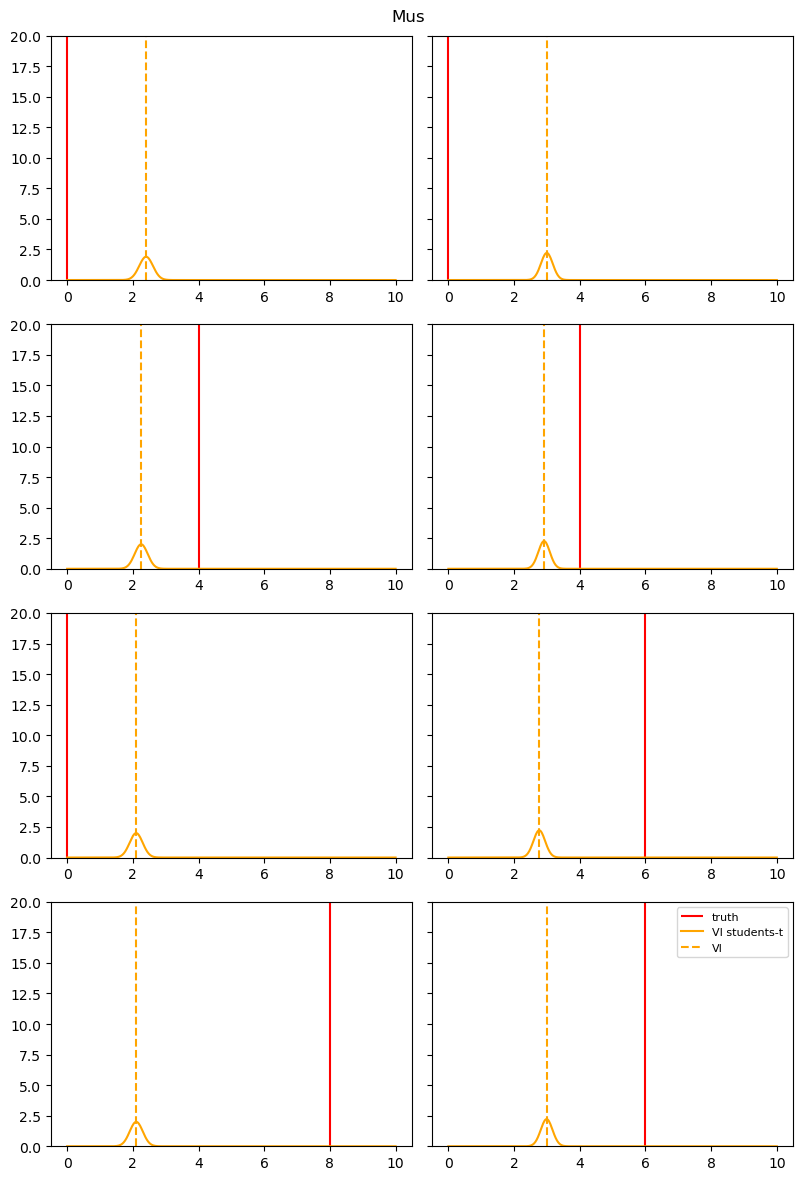

In [ ]:
fig, axs = plt.subplots(K, D,figsize=(8, 12),sharey=True)

for k in range(K):
    for d in range(D):
        ax = axs[k,d]

        ax.vlines(centers[k][d],0,20,color = 'red',label='truth')
        x = np.linspace(0.00001,10,500)
        scale_kd = np.diag(VI_sig[str(k+1)])[d] / (VI_kapp[str(k+1)]*( VI_nu[str(k+1)] + D - 1 ))
        
        ax.plot(x, t.pdf(x, df = VI_nu[str(k+1)], loc=VI_mus[str(k+1)][d], scale=np.sqrt(scale_kd)),label = 'VI students-t',color = 'orange')
        ax.vlines(VI_mus[str(k+1)][d],0,20,color = 'orange',label='VI',linestyles='dashed')

        plt.ylim((0,20))
plt.suptitle('Mus')
plt.legend(fontsize = 8)
plt.tight_layout()


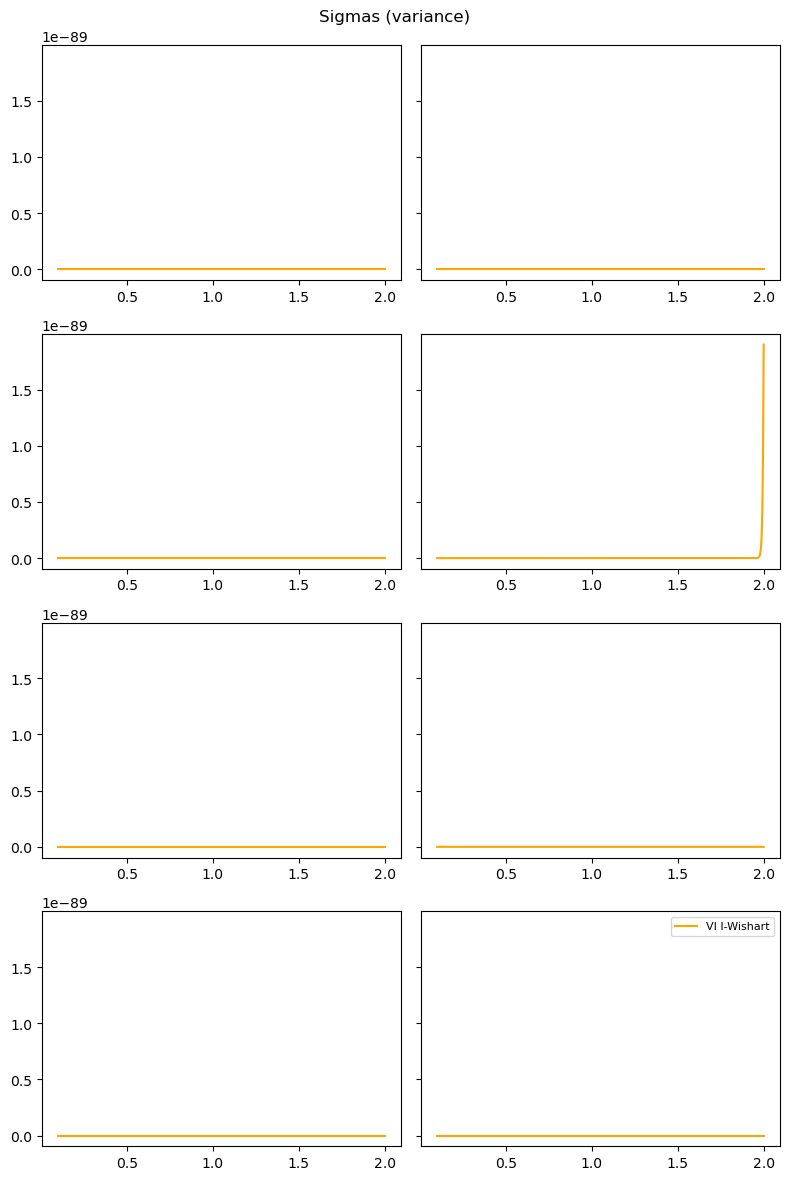

In [ ]:
from scipy.stats import invwishart
fig, axs = plt.subplots(K, D,figsize=(8, 12),sharey = True)
for k in range(K):
    for d in range(D):

        ax = axs[k,d]

        # ax.vlines(1,0,10,color = 'red',label='truth')

        x = np.linspace(0.1,2,500)
        iw = invwishart.pdf(x, df=VI_kapp[str(k+1)], scale = np.diag(VI_sig[str(k+1)])[d])
        ax.plot(x, iw, label = 'VI I-Wishart',color = 'orange')
        
        ax.sharex(axs[:][d][0])

plt.suptitle('Sigmas (variance)')
plt.legend(fontsize = 8)
plt.tight_layout()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


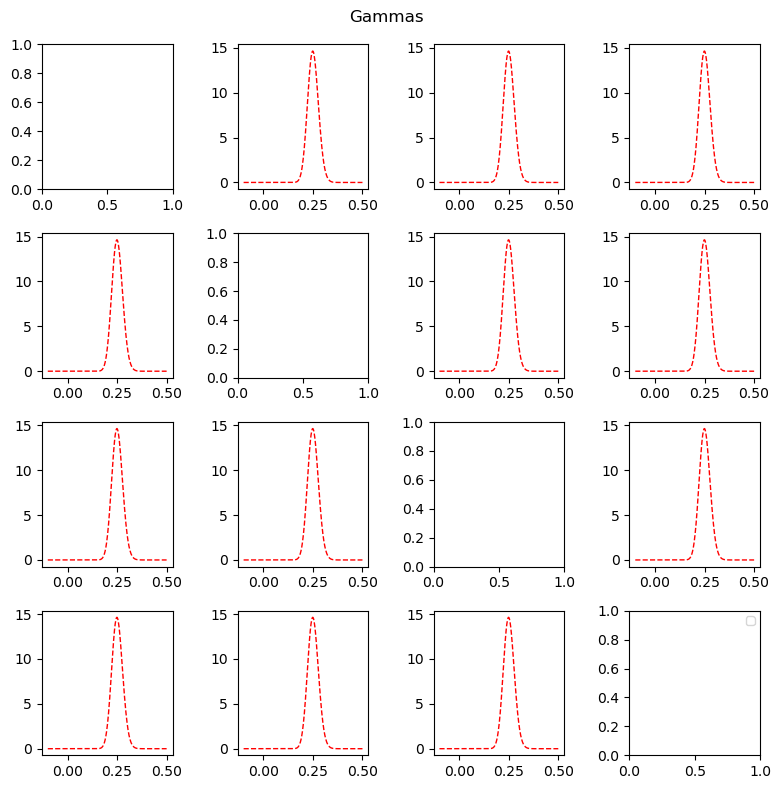

In [ ]:
K=4
fig, axs = plt.subplots(K, K,figsize=(8, 8))#,sharey=  True,sharex=  True
for k in range(K):
    for j in range(K):
        if k==j:
            pass
        else:
            ax = axs[k,j]
            x = np.linspace(-0.1,0.5,500)
            dist = beta.pdf(x,VI_alphas[str(k+1)][str(j+1)] , sum(VI_alphas[str(k+1)].values())-VI_alphas[str(k+1)][str(j+1)])
            ax.plot(x, dist,label = 'VI beta',color = 'red',linewidth=1.0,linestyle = 'dashed')
            # ax.vlines(T[k][j],0,60,color = 'red',label='truth',linewidth=1.0,linestyle = 'dotted')

            # ax.set_xlim(0,1)
            ax.set(ylabel=None)


plt.suptitle('Gammas')
plt.legend(fontsize = 8)
plt.tight_layout()

In [ ]:
VI_alphas

{'3': {'3': 0.0, '1': 1.0, '2': 1.0, '4': 1.0},
 '1': {'3': 1.0, '1': 0.0, '2': 1.0, '4': 1.0},
 '2': {'3': 1.0, '1': 1.0, '2': 999.0, '4': 1.0},
 '4': {'3': 1.0, '1': 1.0, '2': 1.0, '4': 0.0}}